<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/3/MLP_CNN_Example_Galaxy_ZooII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')

from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2
import os, shutil


import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

%load_ext tensorboard


gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0] , True)
    print('Running on GPU ...')
else:
    print('Running on CPU ...')



Running on GPU ...


In [2]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                                       monitor='val_acc',
                                       mode='max',
                                       save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=f'logs', update_freq=100),
]

In [3]:
batch_size = 128
n_w = 200
n_h = 200
n_c = 1
n_classes = 3 # This is only for the first question.

# The number of steps in each epoch
stp_epch =100#  int(61578/ batch_size)+1
stp_epch

100

# Data: Galaxy Zoo

The data here is take from the Galaxy Zoo II survey. For detailed information, see

https://arxiv.org/pdf/1308.3496.pdf

The labels are more involved. Here I simplified the classification problem in the sense that the labels here are only the answers to the first question in the survey, i.e. Is the galaxy simply smooth, and rounded, with no sign of a disk?

answers:

1. smooth,

2. features or disk,

3. star or artifact).

In [4]:
import io, requests, zipfile
import pandas as pd

url_x = "https://www.dropbox.com/s/optw30o55q6mxlw/Cropped%26resized_GS_100_10000_withlabels.npz?dl=1"
url_y = 'https://www.dropbox.com/s/ctjjap42qilhu9s/Y_1.csv?dl=1'

### This file contains classes and the ids.
s=requests.get(url_y, stream=True).content
df = pd.read_csv(io.BytesIO(s), index_col=0)

# ### This file contains images and the ids.
s=requests.get(url_x, stream=True).content
d = np.load(io.BytesIO(s))

# path = 'C:\\Users\\sraeisi\\Documents\\Datasets\\Physics\\Galaxies\\Kaggle\\'

# d = np.load(path+'Cropped&resized_GS_100_10000_withlabels.npz')
# df = pd.read_csv(path+'Y_1.csv', index_col=0)

X, ids = [d[f] for f in ['imgs','ids']]
ids = ids.astype('float')

### We can make the labels based on the ids in the X file.
Y = df.loc[ids].values
print(Y.shape)

(10000, 3)


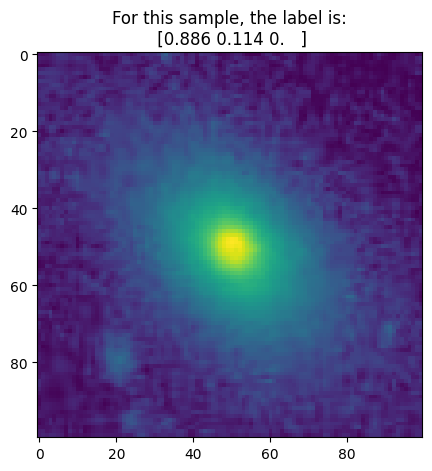

In [6]:
rand_ind = np.random.randint(0,len(Y) )

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1, title =f'For this sample, the label is:\n {Y[rand_ind]}' )
ax.imshow(X[rand_ind])
plt.show()

In [7]:
# For the data we have:
n_w, n_h = X[0].shape
n_f = n_w*n_h
n_c = 1 # number of channles
n_out= 3

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, test_size=.25 )


# To one hot
# from tensorflow.keras import utils
# Y_train = utils.to_categorical(Y_train, n_out)
# Y_test = utils.to_categorical(Y_test, n_out)

## To classes
# Y_train = Y_train.argmax(axis=1)
# Y_test = Y_test.argmax(axis=1)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Let's start with a non-conv net

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers


model = models.Sequential()

model.add(layers.Flatten(input_shape=(n_w , n_h) ))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.1))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,515 (4.88 MB)

 Trainable params: 1,280,515 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train,Y_train,
                    epochs=50, batch_size = 64,
                    # verbose=0 ,
                    callbacks=my_callbacks,
                    validation_data = (X_test, Y_test))

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5021 - loss: 126.2801 - val_accuracy: 0.6012 - val_loss: 1.1875
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5754 - loss: 1.1990 - val_accuracy: 0.5944 - val_loss: 1.1364
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5863 - loss: 1.1496 - val_accuracy: 0.5864 - val_loss: 1.0970
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5674 - loss: 1.1027 - val_accuracy: 0.5872 - val_loss: 1.0624
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5883 - loss: 1.0744 - val_accuracy: 0.5792 - val_loss: 1.0399
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5772 - loss: 1.0465 - val_accuracy: 0.5764 - val_loss: 1.0255
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5866 - loss: 1.0358 - val_accuracy: 0.6008 - val_loss: 1.0183
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6026 - loss: 1.0294 - val_accuracy:

In [ ]:
### If on colab, you can run this to get the tensorboard
%tensorboard --logdir 'logs_{model.name}'

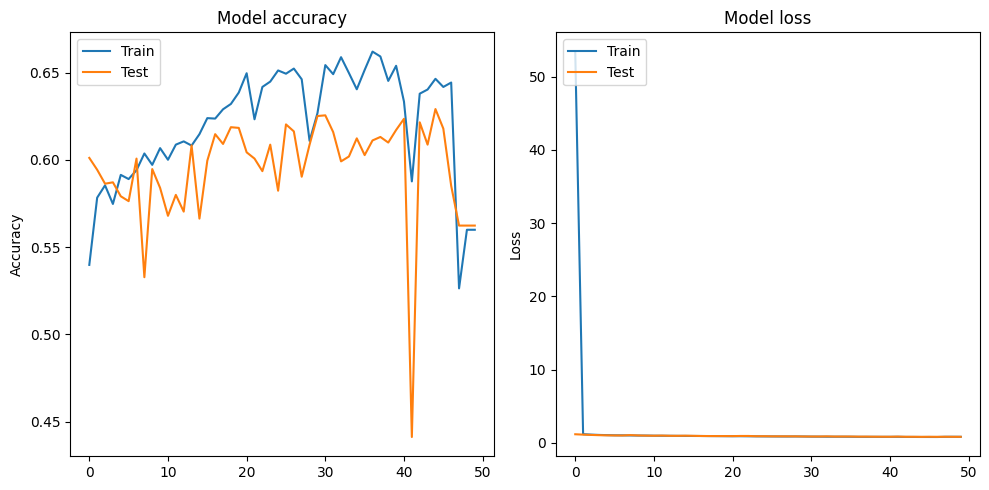

In [11]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

***Question:*** What does these plot tell you? How can you improve this model?

It took 1 min 40 sec to train this model and the acc on the test set is less .7 .

## Simple conv net

In [12]:
# The convolutional layer expects an index for the number of channels,
# So we need ot reshape the input.
# The one at the end indicates the channel.
# in this case, there is only one channel.

X_train = X_train.reshape(-1, n_w, n_h, 1)
X_test = X_test.reshape(-1, n_w, n_h, 1)

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(n_w , n_h, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_out, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,011 (668.01 KB)

 Trainable params: 171,011 (668.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
X_train.shape

(7500, 100, 100, 1)

In [15]:
history = model.fit(X_train,Y_train,
                    epochs=40, batch_size = 256,
                    # verbose=0 ,
                    callbacks=my_callbacks,
                    validation_data = (X_test, Y_test))

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - accuracy: 0.5288 - loss: 2.3702 - val_accuracy: 0.6108 - val_loss: 0.7857
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6428 - loss: 0.7774 - val_accuracy: 0.6936 - val_loss: 0.7570
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7155 - loss: 0.7425 - val_accuracy: 0.7280 - val_loss: 0.7375
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7372 - loss: 0.7318 - val_accuracy: 0.7416 - val_loss: 0.7308
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7593 - loss: 0.7214 - val_accuracy: 0.7440 - val_loss: 0.7264
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7535 - loss: 0.7148 - val_accuracy: 0.7592 - val_loss: 0.7210
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7741 - loss: 0.7091 - val_accuracy: 0.7696 - val_loss: 0.7143
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7867 - loss: 0.7010 - val_accuracy: 0.7660 -

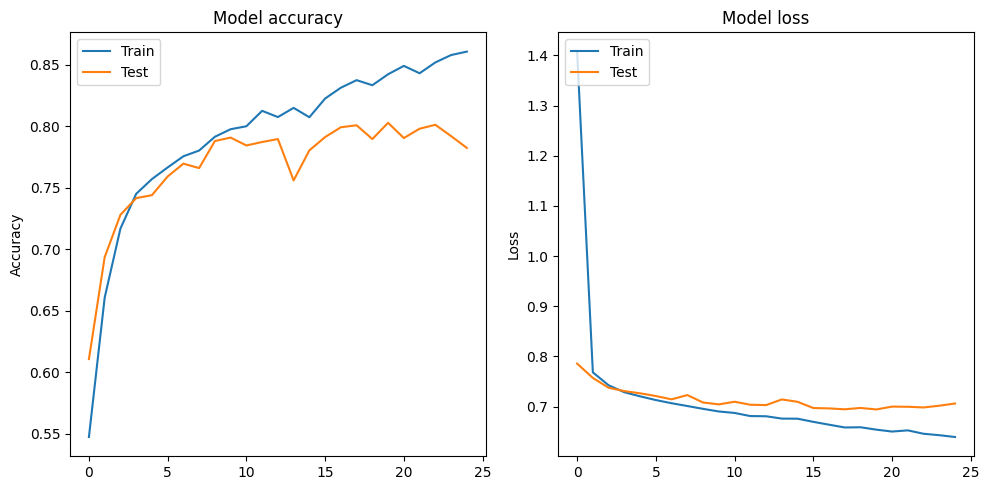

In [16]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Convnet based on some of the famous designs

Look at the link here for a visual introduction to the differnt networks for computer vision applications.

https://arxiv.org/ftp/arxiv/papers/1901/1901.06032.pdf

https://microscope.openai.com/models

https://dataconomy.com/2017/04/history-neural-networks/

![alt text](https://cdn-images-1.medium.com/max/800/1*kBpEOy4fzLiFxRLjpxAX6A.png)



In [17]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [18]:
X_vgg16 = preprocess_input(X)
X_vgg16.shape

(10000, 100, 100)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_vgg16.reshape(-1, n_w, n_h, 1 ),
                                                    Y, random_state=0, test_size=.25 )

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# create the base pre-trained model
model = VGG16(weights=None, include_top=True,
              input_shape=(n_w, n_h,1),
              classes=3)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │    18,878,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,385,603 (192.21 MB)

 Trainable params: 50,385,603 (192.21 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer=optimizers.RMSprop(learning_rate= 2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
X_train = X_train.reshape(-1, n_w, n_h, 1)
X_test = X_test.reshape(-1, n_w, n_h, 1)

# X_c_train = X_c_train.reshape(-1, n_w, n_h, 1)
# X_c_test = X_c_test.reshape(-1, n_w, n_h, 1)

In [24]:
# model.optimizer = optimizers.Adam(learning_rate=.1)
history = model.fit(X_train,Y_train,
                    epochs=10, batch_size = 128,
                    validation_data = (X_test, Y_test),
#                     callbacks=my_callbacks,
                    verbose=1)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5619 - loss: 0.8315 - val_accuracy: 0.6704 - val_loss: 0.7577
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 469ms/step - accuracy: 0.6731 - loss: 0.7633 - val_accuracy: 0.7336 - val_loss: 0.7539
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.7071 - loss: 0.7461 - val_accuracy: 0.7360 - val_loss: 0.7293
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.7245 - loss: 0.7353 - val_accuracy: 0.7024 - val_loss: 0.7505
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 433ms/step - accuracy: 0.7274 - loss: 0.7349 - val_accuracy: 0.7744 - val_loss: 0.7185
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.7590 - loss: 0.7260 - val_accuracy: 0.7716 - val_loss: 0.7153
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - accuracy: 0.7564 - loss: 0.7179 - val_accuracy: 0.7804 - val_loss: 0.7117
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.7614 - loss: 0.7161 - val_accurac

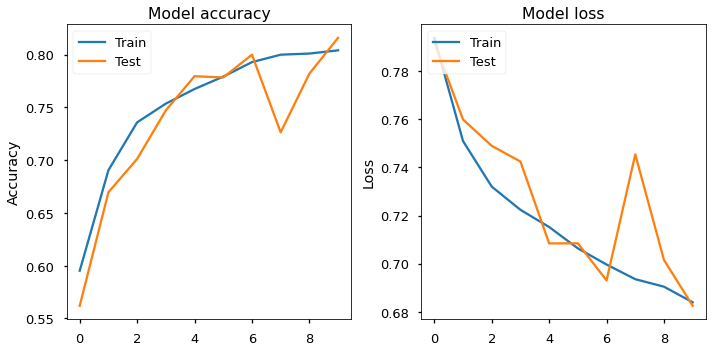

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Transfer learning: Pre-trained Models

In [26]:
X = X.reshape(-1, n_w, n_h, n_c)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, test_size=.25 )
# X_c_train, X_c_test, Y_c_train, Y_c_test = train_test_split(X,Y_c, random_state=0, test_size=.25 )

In [27]:
# We need to format the data according to the inputs of VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16

X_3c = np.dstack([X]*3).reshape(-1, n_w, n_h, 3)
X_vgg16_3c = preprocess_input(X_3c)
Y_c = np.argmax(Y,axis=1)

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=180,
                                   validation_split=0.5)

train_generator = train_datagen.flow( X_vgg16_3c, Y_c,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     subset='training')

validation_generator = train_datagen.flow( X_vgg16_3c, Y_c,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     subset='validation')

## Pretrained VGG16 as a feature extractor

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, losses

# create the base pre-trained model
vgg16_base = VGG16(weights='imagenet', include_top=False,
              input_shape=(n_w, n_h,3),
              )

vgg16_base.trainable = False
vgg16_base.trainable

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


False

In [32]:
vgg16_base_out = vgg16_base.layers[-1].output.shape[1:]
n_features = np.prod(vgg16_base_out)
vgg16_base_out

(3, 3, 512)

In [34]:
'''
This function is to exctract features from the images.
This is done based on VGG16 convnet.
This function does the following

X, Y => f(X), Y

where f(x) is the feasures extracted from the images.

'''

def extract_features(network, generator, sample_count):
    ## This is set based on the shape of the last layer of the VGG16
    features = np.zeros(shape=(sample_count, vgg16_base_out[0], vgg16_base_out[1], vgg16_base_out[2] ))
    labels = np.zeros(shape=(sample_count))

    i = 0
    for batch_x, batch_y in generator:
        batch_extfeaures = network.predict(batch_x)
#         print(batch_y.shape)
        features[i * batch_size : (i + 1) * batch_size] = batch_extfeaures
        labels[i * batch_size : (i + 1) * batch_size] = batch_y
        i += 1
#         print(i)
        if i * batch_size >= sample_count:
            break
    return features, labels



In [35]:
%%time
train_features, train_labels = extract_features(vgg16_base, train_generator, 20*batch_size)
validation_features, validation_labels = extract_features(vgg16_base, validation_generator, 10*batch_size)

## The data needs to be flattened.
train_features = np.reshape(train_features, (20*batch_size, n_features))
validation_features = np.reshape(validation_features, (10*batch_size, n_features ))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━

In [38]:
'''
Now let's make our new model.
'''
feature_based_model = models.Sequential()

feature_based_model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 512))
# feature_based_model.add(layers.Dropout(0.5))

feature_based_model.add(layers.Dense(3, activation='softmax'))

feature_based_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
             metrics=['accuracy'])

feature_based_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,675 (4.50 MB)

 Trainable params: 1,180,675 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = feature_based_model.fit(train_features, train_labels,
                                epochs=20,
                                batch_size=batch_size,
                                validation_data= (validation_features, validation_labels),
#                                 callbacks=my_callbacks,
                                verbose=1 )

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5578 - loss: 1.2051 - val_accuracy: 0.5781 - val_loss: 0.6735
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5674 - loss: 0.6800 - val_accuracy: 0.5781 - val_loss: 0.6601
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5888 - loss: 0.6635 - val_accuracy: 0.7023 - val_loss: 0.6394
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6392 - loss: 0.6403 - val_accuracy: 0.6008 - val_loss: 0.6248
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6298 - loss: 0.6430 - val_accuracy: 0.6172 - val_loss: 0.6289
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6248 - loss: 0.6336 - val_accuracy: 0.5414 - val_loss: 0.6887
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6391 - loss: 0.6274 - val_accuracy: 0.5813 - val_loss: 0.7198
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6855 - loss: 0.6346 - val_accuracy: 0.6867 - val_loss

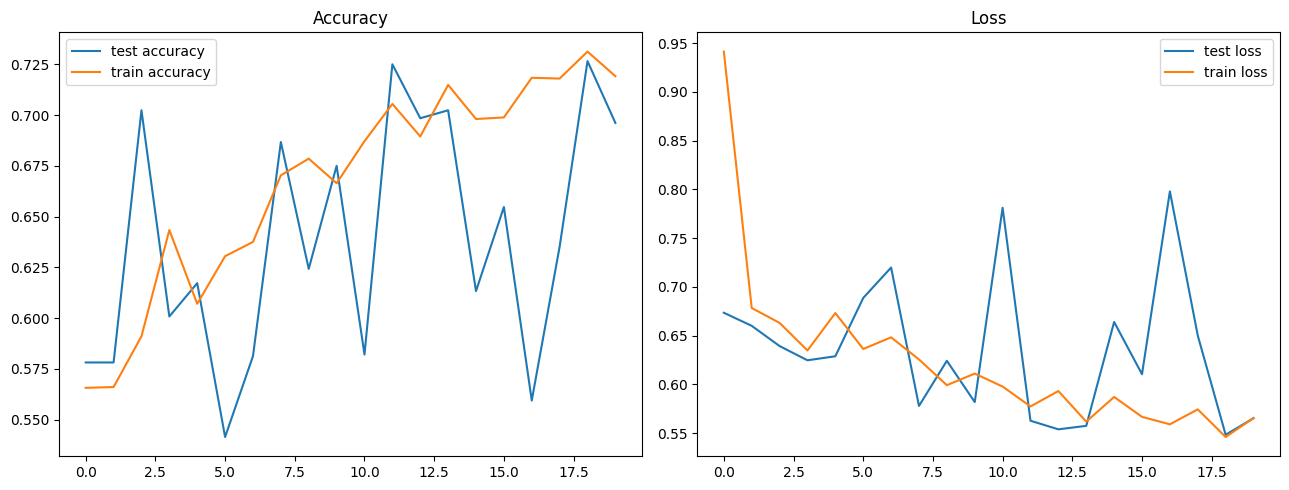

In [40]:
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


## Pretrained VGG16 + classifier at the end

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, losses

# create the base pre-trained model
vgg16_base = VGG16(weights='imagenet', include_top=False,
              input_shape=(n_w, n_h,3),
              )

vgg16_base.trainable = False


In [55]:
'''
Now let's make our new model.
'''
pre_trained_model = models.Sequential()

pre_trained_model.add(vgg16_base)

pre_trained_model.add(layers.Flatten())

pre_trained_model.add(layers.Dense(256, activation='relu' ))
# pre_trained_model.add(layers.Dropout(0.5))

pre_trained_model.add(layers.Dense(3, activation='softmax'))

pre_trained_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
             metrics=['accuracy'])

pre_trained_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,895,363 (60.64 MB)

 Trainable params: 1,180,675 (4.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
print(vgg16_base.trainable)

False


In [52]:
train_generator[0][0].shape

(128, 100, 100, 3)

In [53]:
stp_epch

100

In [56]:
%%time
############### Training the model

history = pre_trained_model.fit(train_generator,
                    validation_data  = validation_generator,
                    validation_steps = 5,
#                     callbacks = my_callbacks,
                    verbose = 1,
                    epochs = 20)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step - accuracy: 0.5210 - loss: 1.0112 - val_accuracy: 0.5641 - val_loss: 0.6743
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.5981 - loss: 0.6628 - val_accuracy: 0.6922 - val_loss: 0.6259
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - accuracy: 0.6401 - loss: 0.6853 - val_accuracy: 0.5266 - val_loss: 0.7767
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 508ms/step - accuracy: 0.6163 - loss: 0.7740 - val_accuracy: 0.6516 - val_loss: 0.6173
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 382ms/step - accuracy: 0.6448 - loss: 0.6306 - val_accuracy: 0.7047 - val_loss: 0.5864
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - accuracy: 0.6268 - loss: 0.6864 - val_accuracy: 0.6984 - val_loss: 0.5867
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step - accuracy: 0.6783 - loss: 0.6199 - val_accuracy: 0.4984 - val_loss: 0.8810
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.6603 - loss: 0.6341 - val_accu

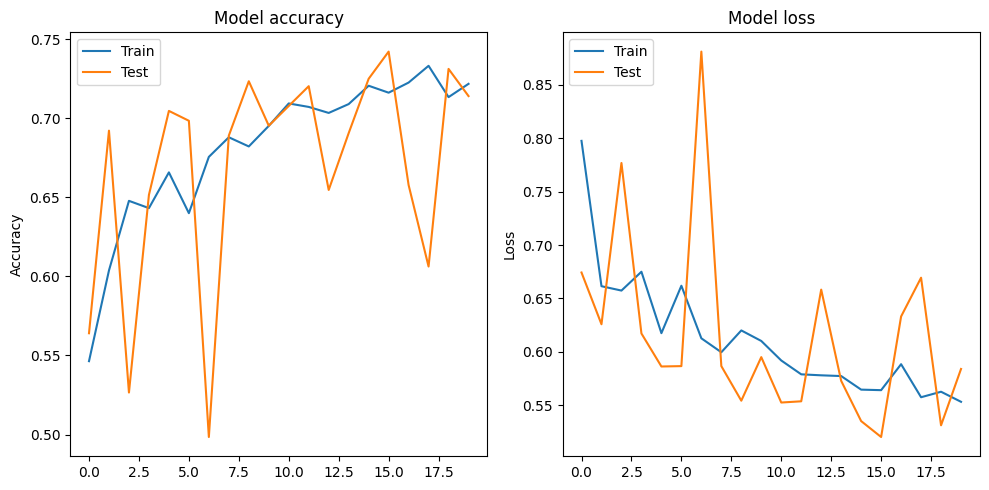

In [57]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Partially Freezed conv_base

In [58]:
for layer in model.layers[:-1]:
    layer.trainable = False

for layer in model.layers:
    print(layer.name, layer.trainable  )

vgg16 False
flatten_8 False
dense_22 False
dense_23 True


In [59]:
vgg16_base.trainble = False

# We can freeze all bu the last two layers.
for layer in vgg16_base.layers[-3:]:
    layer.trainable = True

## We can check which layers are traible.
i=0
for layer in vgg16_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: False
Layer 15 is trainable: False
Layer 16 is trainable: False
Layer 17 is trainable: True
Layer 18 is trainable: True
Layer 19 is trainable: True


In [61]:
pre_trained_model = models.Sequential()
pre_trained_model.add(vgg16_base)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(feature_based_model)

pre_trained_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
             metrics=['accuracy'])


pre_trained_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 3)              │     1,180,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,895,363 (60.64 MB)

 Trainable params: 5,900,291 (22.51 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [64]:
# Even without training, this returns high accuracy.
from tensorflow.keras.losses import mse
from sklearn.metrics import accuracy_score

loss = 0
acc = 0
n_val =10

for i in range(n_val):
    d = validation_generator[i]
    y_prd = pre_trained_model.predict(d[0]).argmax(axis=1)

    loss += mse(y_prd, d[1]).numpy().mean()/n_val
    acc += accuracy_score( y_prd,   d[1] )/n_val


print(f'The score before training is {acc}.')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The score before training is 0.6648437500000001.


In [65]:
history = pre_trained_model.fit(train_generator,
                    # steps_per_epoch  = stp_epch,
                    validation_data  = validation_generator,
                    validation_steps = 5,
                    callbacks = my_callbacks,
                    verbose = 1,
                    epochs = 5)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.5521 - loss: 0.9831 - val_accuracy: 0.5953 - val_loss: 0.6596
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - accuracy: 0.5484 - loss: 0.7165 - val_accuracy: 0.5906 - val_loss: 0.6837
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 414ms/step - accuracy: 0.5912 - loss: 0.6749 - val_accuracy: 0.6734 - val_loss: 0.6249
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.6934 - loss: 0.6037 - val_accuracy: 0.7297 - val_loss: 0.5395
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 514ms/step - accuracy: 0.7209 - loss: 0.5592 - val_accuracy: 0.7531 - val_loss: 0.5324


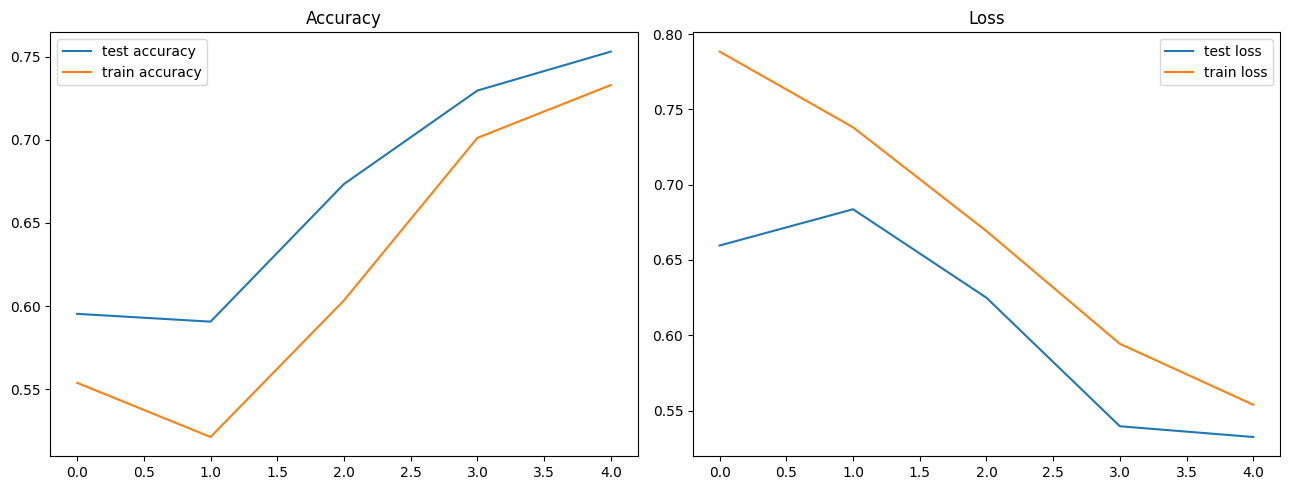

In [66]:
##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


## Adding more trainable layers
Now we can unfreeze more layers and gradually fine tune the conv-base too.

In [67]:
vgg16_base.trainble = False

# We can freeze all bu the last two layers.
for layer in vgg16_base.layers[-6:]:
    layer.trainable = True

## We can check which layers are traible.
i=0
for layer in vgg16_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: True
Layer 15 is trainable: True
Layer 16 is trainable: True
Layer 17 is trainable: True
Layer 18 is trainable: True
Layer 19 is trainable: True


In [71]:
pre_trained_model = models.Sequential()
pre_trained_model.add(vgg16_base)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(feature_based_model)

pre_trained_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
             metrics=['accuracy'])


# pre_trained_model.summary()

history = pre_trained_model.fit(train_generator,
                    steps_per_epoch  = stp_epch,
                    validation_data  = validation_generator,
                    validation_steps = 5,
                    callbacks = my_callbacks,
                    verbose = 1,
                    epochs = 3)

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.5831 - loss: 0.8265 - val_accuracy: 0.5328 - val_loss: 0.7112
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.6998 - loss: 0.6058 - val_accuracy: 0.7641 - val_loss: 0.5231
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7613 - loss: 0.5201 - val_accuracy: 0.7734 - val_loss: 0.4775


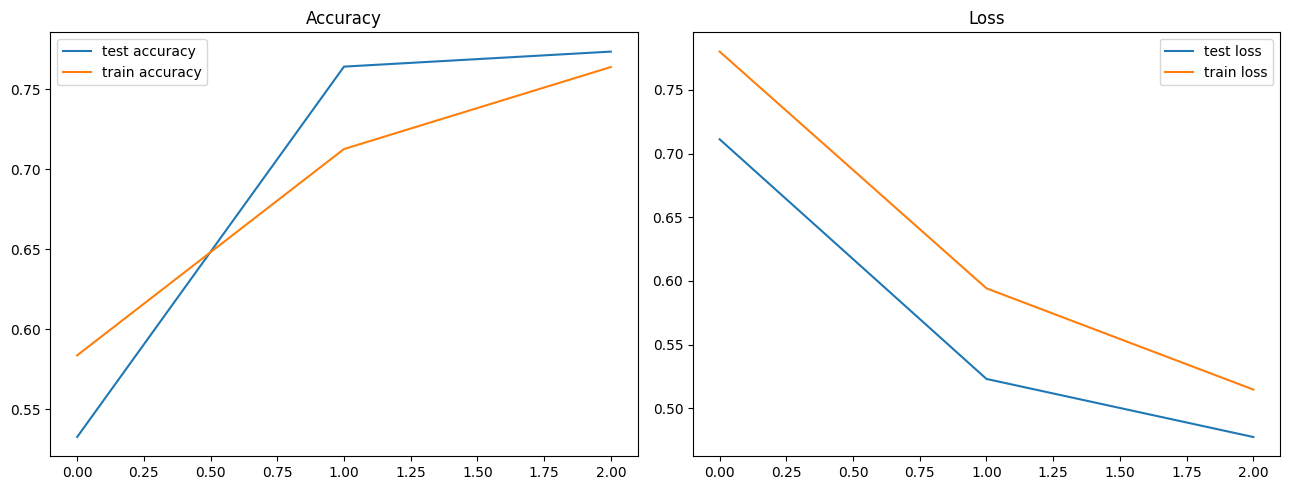

In [72]:
##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


In [73]:
model.save('sample_model.h5')